In [1]:
import xml.etree.ElementTree as ET

In [2]:
tree = ET.parse('export.xml') 
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

In [3]:
for record in record_list[:5]: 
    print(record)

{'type': 'HKQuantityTypeIdentifierBodyMassIndex', 'sourceName': 'Health', 'sourceVersion': '14.3', 'unit': 'count', 'creationDate': '2021-01-23 17:41:19 +0000', 'startDate': '2021-01-23 17:41:00 +0000', 'endDate': '2021-01-23 17:41:00 +0000', 'value': '27.43'}
{'type': 'HKQuantityTypeIdentifierBodyMassIndex', 'sourceName': 'Withings', 'sourceVersion': '5130104', 'unit': 'count', 'creationDate': '2023-01-12 18:43:31 +0000', 'startDate': '2023-01-12 18:42:13 +0000', 'endDate': '2023-01-12 18:42:13 +0000', 'value': '28.075'}
{'type': 'HKQuantityTypeIdentifierHeight', 'sourceName': 'Paul’s IPhone 13', 'sourceVersion': '15.2.1', 'unit': 'cm', 'creationDate': '2022-01-22 16:04:04 +0000', 'startDate': '2022-01-22 16:04:04 +0000', 'endDate': '2022-01-22 16:04:04 +0000', 'value': '174'}
{'type': 'HKQuantityTypeIdentifierHeight', 'sourceName': 'Health', 'sourceVersion': '9.2.1', 'unit': 'cm', 'creationDate': '2016-03-17 17:39:53 +0000', 'startDate': '2016-03-17 17:39:00 +0000', 'endDate': '2016-

In [4]:
#%run -i 'apple-health-data-parser' 'export.xml'

In [33]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [18]:
activity_summary = pd.read_csv('ActivitySummary.csv')
activity_summary.head()

,dateComponents,activeEnergyBurned,activeEnergyBurnedGoal,activeEnergyBurnedUnit,appleExerciseTime,appleExerciseTimeGoal,appleStandHours,appleStandHoursGoal
0,2021-11-20,0.000,0,kcal,0,30,0,12
1,2021-11-21,0.000,0,kcal,0,30,0,12
2,2022-01-21,0.000,0,kcal,0,30,0,12
3,2022-01-22,134.935,650,kcal,0,30,6,12
4,2022-01-23,1154.850,650,kcal,130,30,18,12


In [19]:
activity_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dateComponents          790 non-null    object 
 1   activeEnergyBurned      790 non-null    float64
 2   activeEnergyBurnedGoal  790 non-null    int64  
 3   activeEnergyBurnedUnit  790 non-null    object 
 4   appleExerciseTime       790 non-null    int64  
 5   appleExerciseTimeGoal   790 non-null    int64  
 6   appleStandHours         790 non-null    int64  
 7   appleStandHoursGoal     790 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 49.5+ KB


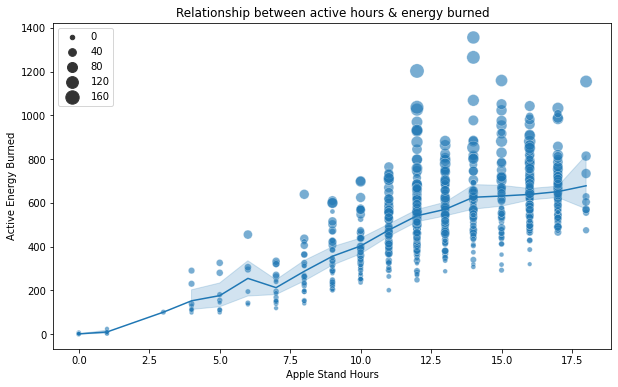

In [37]:
df = activity_summary[['appleStandHours', 'activeEnergyBurned', 'appleExerciseTime']]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='appleStandHours', y='activeEnergyBurned', size='appleExerciseTime', sizes=(20, 200), alpha=0.6)
sns.lineplot(data=df, x='appleStandHours', y='activeEnergyBurned')

plt.title('Relationship between active hours & energy burned')
plt.xlabel('Apple Stand Hours')
plt.ylabel('Active Energy Burned')
plt.show()

We observe a positive correlation between the amount of energy burned and the duration of standing hours (StandHours), suggesting that individuals tend to burn more energy when they are physically active. Additionally, there is a positive relationship between energy burned and exercise time (ExerciseTime), although this association may not always hold true. Therefore, recording activity levels during periods of high ExerciseTime and EnergyBurned, as well as during high ExerciseTime but low EnergyBurned, can provide valuable insights for modeling these relationships more accurately.

Alternatively, using time as a proxy for the type of exercise can also provide valuable context. For instance, categorizing morning activities as cycling and evening routines as cycling followed by gym sessions can enhance our understanding of progression of heart rate over years

In [273]:
workout_data = pd.read_csv('Workout.csv')
heart_rate_data = pd.read_csv('HeartRate.csv')


activity_summary['startDate'] = activity_summary['dateComponents']
workout_data['startDate'] = pd.to_datetime(workout_data['startDate'])
activity_summary['startDate'] = pd.to_datetime(activity_summary['startDate'])

workout_data['startDate'] = pd.to_datetime(workout_data['startDate']).dt.date
workout_data['startDate']=pd.to_datetime(workout_data['startDate'])


merged_data1 = pd.merge(workout_data, activity_summary, on='startDate', how='inner')

heart_rate_data['startDate'] = pd.to_datetime(heart_rate_data['startDate']).dt.date
heart_rate_data['startDate']=pd.to_datetime(heart_rate_data['startDate'])

merged_data2 = pd.merge(merged_data1, heart_rate_data, on='startDate', how='inner')

In [274]:
merged_data2['workoutActivityType'] = merged_data2['workoutActivityType'].replace({
    'HKWorkoutActivityTypeWalking': 'Walking',
    'HKWorkoutActivityTypeCycling': 'Cycling'
})

In [248]:
#Encode Cycling:0 and Walking:1
merged_data2['workoutActivityType1']=merged_data2['workoutActivityType']
merged_data2['workoutActivityType1'] = merged_data2['workoutActivityType1'].replace({'Cycling': 0, 'Walking': 1})

In [261]:
X = merged_data2[[ 'duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1']]
y = merged_data2['value'].values
dates = merged_data2['startDate']

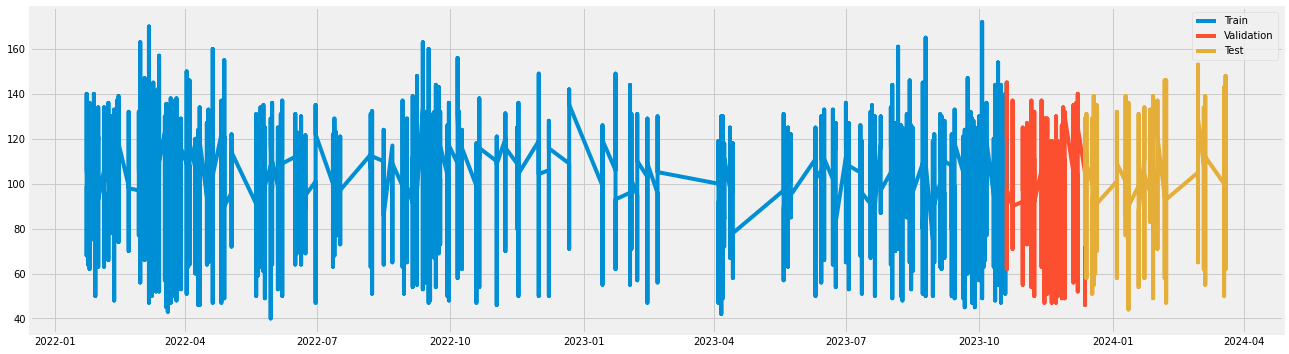

In [262]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20, 6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

We observe a gradual decline in heart rate with age, a natural phenomenon influenced by various physiological changes. However, engaging in regular exercise can help maintain heart health and mitigate this decline. By staying physically active, individuals can support their cardiovascular system, ensuring that their heart rate remains within healthy ranges despite the aging process.

In [250]:
data=merged_data2[['duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1','value']]
target=data.value
covs=merged_data2[['duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1']]

In [251]:
from sklearn import linear_model

#Lets try to smooth the heart rate data by adjusting for exercise time, type of activity and duration
def regressOut(y, X, use_fit=None):
    lm = linear_model.LinearRegression()    
    if use_fit is None:
        use_fit = [True] * X.shape[0]
    else:
        use_fit = use_fit.values

    x_mean = X.iloc[use_fit,:].mean()
    lm.fit(X.loc[use_fit,:].values, y.loc[use_fit])
    yhat = lm.predict(X.values)
    res = y - yhat
    offset = lm.predict(x_mean.values.reshape(1, -1))
    return(res + offset)

In [252]:
data_regress = data.apply(lambda target: regressOut(target, covs))

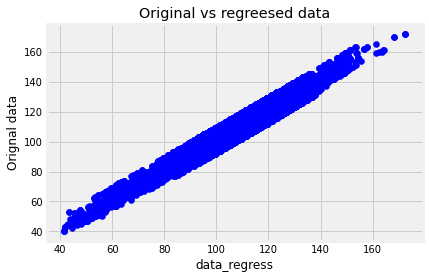

In [256]:
# Plot scatter plot
plt.scatter(data_regress.value, merged_data2.value, color='blue')
plt.xlabel('data_regress')
plt.ylabel('Orignal data')
plt.title('Original vs regreesed data')
plt.show()

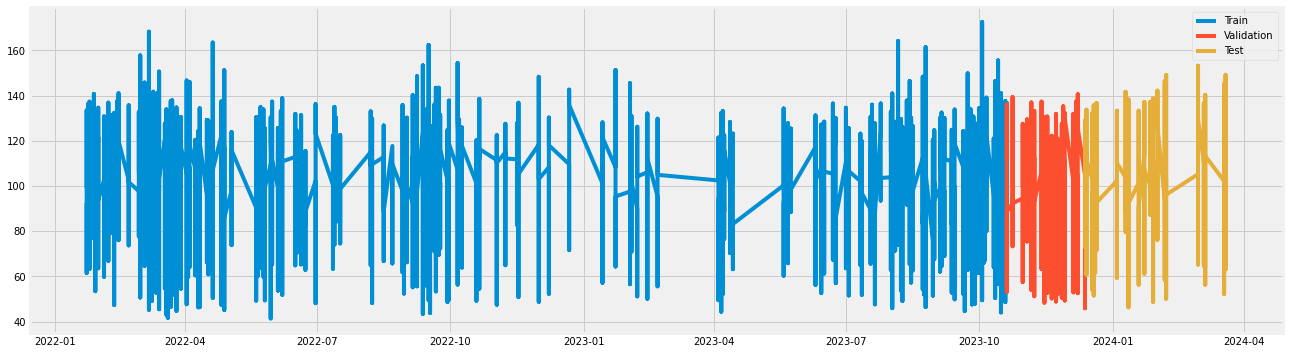

In [264]:
X_regr = data_regress[[ 'duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1']]
y_regr = data_regress['value'].values
dates_regr = merged_data2['startDate']

dates_train_regr, X_train_regr, y_train_regr = dates_regr[:q_80], X_regr[:q_80], y_regr[:q_80]
dates_val_regr, X_val_regr, y_val_regr = dates_regr[q_80:q_90], X_regr[q_80:q_90], y_regr[q_80:q_90]
dates_test_regr, X_test_regr, y_test_regr = dates_regr[q_90:], X_regr[q_90:], y_regr[q_90:]

plt.figure(figsize=(20, 6))
plt.plot(dates_train_regr, y_train_regr)
plt.plot(dates_val_regr, y_val_regr)
plt.plot(dates_test_regr, y_test_regr)

plt.legend(['Train', 'Validation', 'Test'])

In [245]:
label_encoder = LabelEncoder()
scaler = StandardScaler()
X_train[['duration', 'activeEnergyBurned', 'appleExerciseTime']] = scaler.fit_transform(X_train[['duration', 'activeEnergyBurned', 'appleExerciseTime']])

# Convert DataFrame to numpy array
X_train = X_train.values
X_test=X_test.values

# Reshape X_train to add the third dimension
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model = Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  # Specify input shape
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)


/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_63983/374960737.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
4307/4307 [==============================] - 13s 3ms/step - loss: 377.5406 - mean_absolute_error: 12.0381 - val_loss: 1003.3320 - val_mean_absolute_error: 29.6951
Epoch 2/100
4307/4307 [==============================] - 10s 2ms/step - loss: 157.1767 - mean_absolute_error: 9.9839 - val_loss: 1218.8939 - val_mean_absolute_error: 33.0769
Epoch 3/100
4307/4307 [==============================] - 10s 2ms/step - loss: 156.2090 - mean_absolute_error: 9.9559 - val_loss: 1549.9978 - val_mean_absolute_error: 37.7003
Epoch 4/100
4307/4307 [==============================] - 10s 2ms/step - loss: 155.7186 - mean_absolute_error: 9.9438 - val_loss: 2343.7092 - val_mean_absolute_error: 47.0062
Epoch 5/100
4307/4307 [==============================] - 10s 2ms/step - loss: 155.1593 - mean_absolute_error: 9.9322 - val_loss: 2384.8994 - val_mean_absolute_error: 47.4681
Epoch 6/100
4307/4307 [==============================] - 11s 3ms/step - loss: 154.8789 - mean_absolute_error: 9.9225 - val_loss: 

Epoch 48/100
4307/4307 [==============================] - 10s 2ms/step - loss: 139.7586 - mean_absolute_error: 9.3526 - val_loss: 4360.0391 - val_mean_absolute_error: 64.9831
Epoch 49/100
4307/4307 [==============================] - 10s 2ms/step - loss: 139.5102 - mean_absolute_error: 9.3484 - val_loss: 4025.0857 - val_mean_absolute_error: 62.3617
Epoch 50/100
4307/4307 [==============================] - 10s 2ms/step - loss: 139.6053 - mean_absolute_error: 9.3507 - val_loss: 4198.1870 - val_mean_absolute_error: 63.7076
Epoch 51/100
4307/4307 [==============================] - 10s 2ms/step - loss: 139.4482 - mean_absolute_error: 9.3482 - val_loss: 4218.2109 - val_mean_absolute_error: 63.8735
Epoch 52/100
4307/4307 [==============================] - 10s 2ms/step - loss: 139.3997 - mean_absolute_error: 9.3367 - val_loss: 4284.0093 - val_mean_absolute_error: 64.3855
Epoch 53/100
4307/4307 [==============================] - 9s 2ms/step - loss: 139.3505 - mean_absolute_error: 9.3369 - val_lo

Epoch 95/100
4307/4307 [==============================] - 10s 2ms/step - loss: 137.9895 - mean_absolute_error: 9.2935 - val_loss: 4690.2866 - val_mean_absolute_error: 67.4952
Epoch 96/100
4307/4307 [==============================] - 9s 2ms/step - loss: 138.0671 - mean_absolute_error: 9.2929 - val_loss: 4848.0220 - val_mean_absolute_error: 68.6539
Epoch 97/100
4307/4307 [==============================] - 12s 3ms/step - loss: 138.1369 - mean_absolute_error: 9.2935 - val_loss: 4797.6284 - val_mean_absolute_error: 68.2867
Epoch 98/100
4307/4307 [==============================] - 11s 3ms/step - loss: 137.8927 - mean_absolute_error: 9.2854 - val_loss: 4915.7612 - val_mean_absolute_error: 69.1471
Epoch 99/100
4307/4307 [==============================] - 11s 2ms/step - loss: 137.9876 - mean_absolute_error: 9.2884 - val_loss: 4865.2954 - val_mean_absolute_error: 68.7794
Epoch 100/100
4307/4307 [==============================] - 10s 2ms/step - loss: 138.0462 - mean_absolute_error: 9.2941 - val_l

4307/4307 [==============================] - 6s 1ms/step


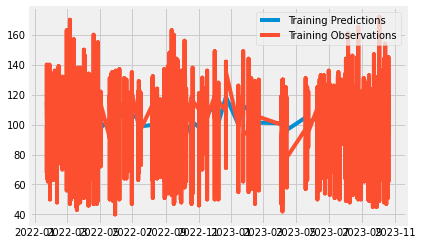

In [246]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [257]:
#Retrain new model, this time include workoutActivityType1 as a feature
merged_data3=merged_data2[['workoutActivityType1','duration', 'activeEnergyBurned', 'appleExerciseTime']]
scaler = StandardScaler()
merged_data3[['duration', 'activeEnergyBurned', 'appleExerciseTime']] = scaler.fit_transform(merged_data3[['duration', 'activeEnergyBurned', 'appleExerciseTime']])
X = merged_data3.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model1 = Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])), 
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model1.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_63983/4157694407.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/100
4307/4307 [==============================] - 16s 3ms/step - loss: 357.8421 - mean_absolute_error: 11.7887 - val_loss: 154.8448 - val_mean_absolute_error: 9.8690
Epoch 2/100
4307/4307 [==============================] - 13s 3ms/step - loss: 155.1320 - mean_absolute_error: 9.9188 - val_loss: 152.9855 - val_mean_absolute_error: 9.8681
Epoch 3/100
4307/4307 [==============================] - 13s 3ms/step - loss: 154.0206 - mean_absolute_error: 9.8822 - val_loss: 153.8288 - val_mean_absolute_error: 9.8125
Epoch 4/100
4307/4307 [==============================] - 14s 3ms/step - loss: 153.5665 - mean_absolute_error: 9.8612 - val_loss: 151.7688 - val_mean_absolute_error: 9.7944
Epoch 5/100
4307/4307 [==============================] - 16s 4ms/step - loss: 153.0170 - mean_absolute_error: 9.8393 - val_loss: 152.2791 - val_mean_absolute_error: 9.7769
Epoch 6/100
4307/4307 [==============================] - 14s 3ms/step - loss: 152.9038 - mean_absolute_error: 9.8312 - val_loss: 150.9333 -

4307/4307 [==============================] - 11s 3ms/step - loss: 138.0817 - mean_absolute_error: 9.2975 - val_loss: 137.8864 - val_mean_absolute_error: 9.3135
Epoch 96/100
4307/4307 [==============================] - 11s 3ms/step - loss: 138.0484 - mean_absolute_error: 9.2943 - val_loss: 137.7986 - val_mean_absolute_error: 9.3282
Epoch 97/100
4307/4307 [==============================] - 11s 3ms/step - loss: 138.0883 - mean_absolute_error: 9.2925 - val_loss: 138.6161 - val_mean_absolute_error: 9.3861
Epoch 98/100
4307/4307 [==============================] - 11s 3ms/step - loss: 138.0135 - mean_absolute_error: 9.2918 - val_loss: 138.5725 - val_mean_absolute_error: 9.2668
Epoch 99/100
4307/4307 [==============================] - 11s 3ms/step - loss: 137.8268 - mean_absolute_error: 9.2851 - val_loss: 139.1993 - val_mean_absolute_error: 9.2850
Epoch 100/100
4307/4307 [==============================] - 12s 3ms/step - loss: 137.8159 - mean_absolute_error: 9.2861 - val_loss: 138.0474 - val_me

4307/4307 [==============================] - 5s 1ms/step


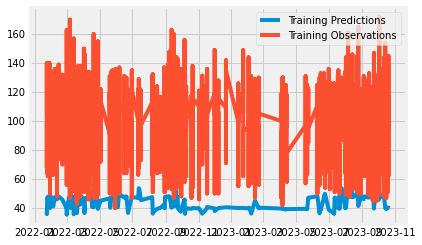

In [267]:
train_predictions = model1.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

539/539 [==============================] - 2s 2ms/step


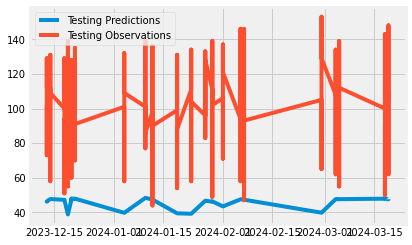

In [265]:
test_predictions = model1.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])